In [5]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [6]:
# function to load and process image
def load_image_from_image_dataset(folder_path, target_size=(64,64)):
    images = [] # to store the resized images as array 
    labels = [] # to store names of the folder(person) inside the dataset 
    label_map = {}
    label_id = 0 #used to label the images instead of foldernames of the person

    for folder_name in os.listdir(folder_path):
        sub_path= os.path.join(folder_path, folder_name)
        if not os.path.isdir(sub_path):
            continue

        label_map[label_id] = folder_name
        current_label = label_id
        label_id+=1
        
        for filename in os.listdir(sub_path):
            image_path= os.path.join(sub_path, filename)
            try:
                img=cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)

                if img is None:
                    print(f"Warning: Could not read {filename}")
                    continue

                img_resized=cv2.resize(img,target_size)
                images.append(img_resized)
                labels.append(current_label)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
    
    return np.array(images).T, np.array(labels), label_map


In [7]:
# function to train eigenfaces
def train_eigenfaces(image_matrix):

    mean, eigenvectors, eigenvalues=cv2.PCACompute2(image_matrix.T, None) # opencv will compute eigenvectors(eigenfaces) and also the mean
    return mean, eigenvectors, eigenvalues

Shape of train images:  (64, 64, 8)
shape of mean face (1, 4096)
shape of  eigenface (8, 4096)


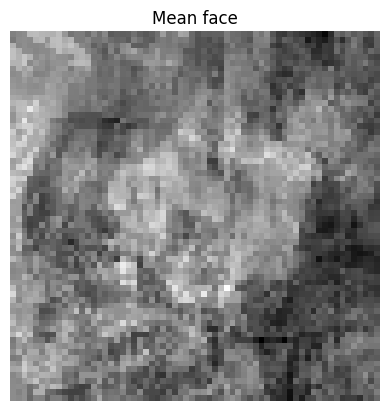

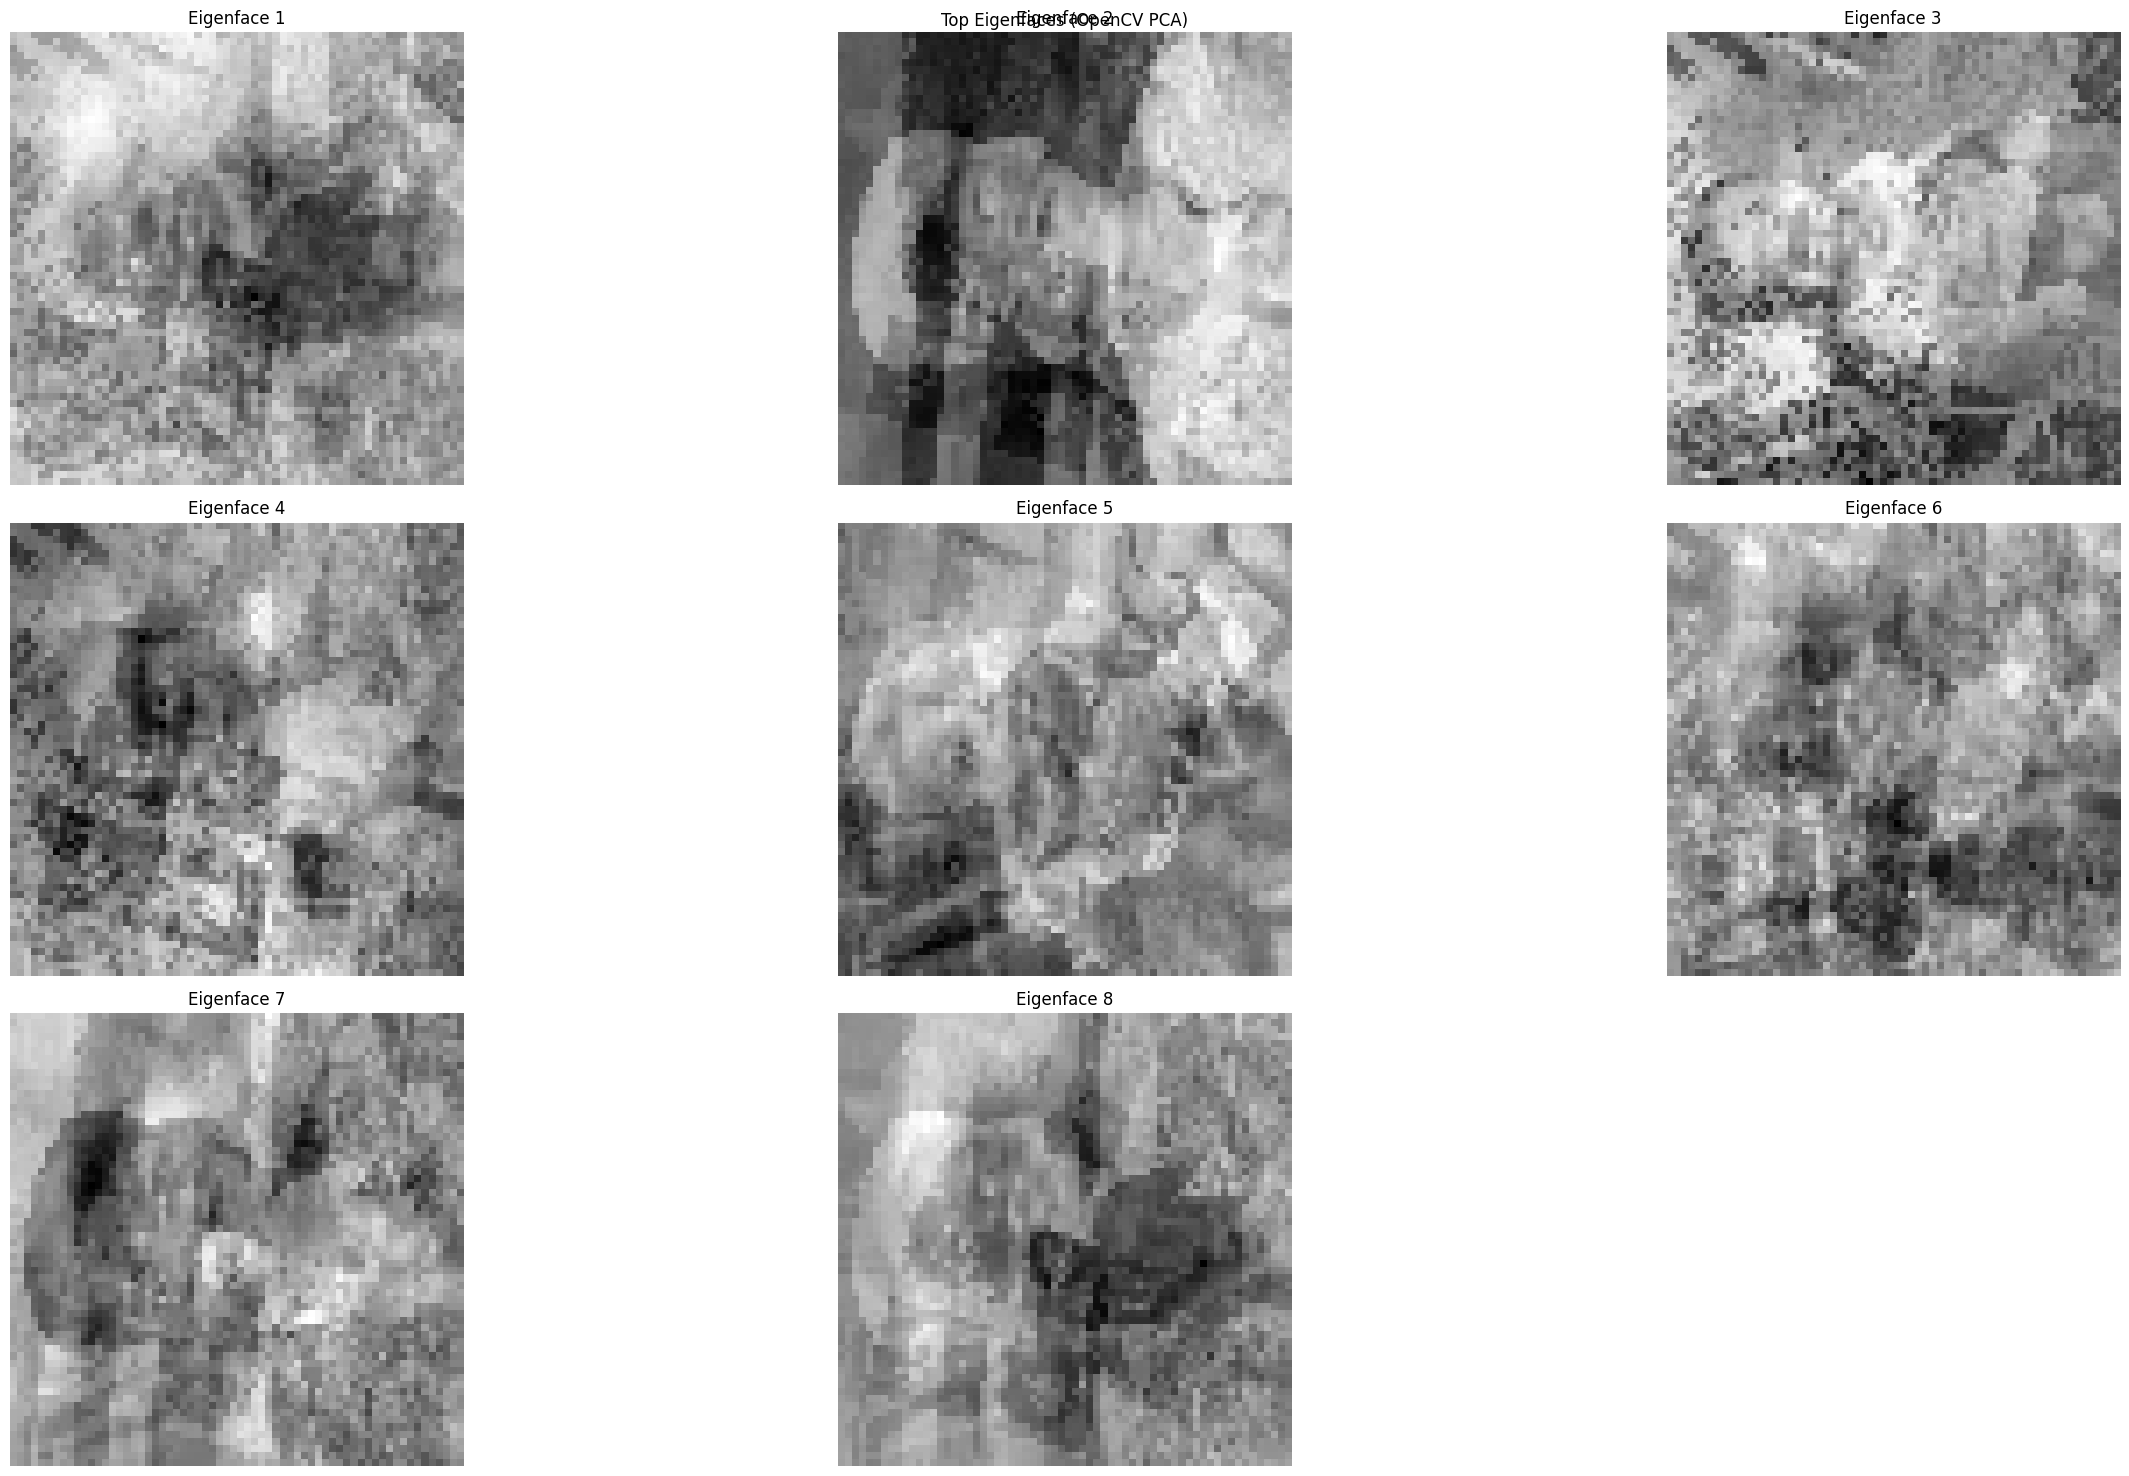

In [ ]:
# using for training
train_folder = "face_dataset"
# img=cv2.imread("/Users/kumarswamikallimath/Desktop/EigenFaces/face_dataset/Anu/image1.jpeg",0)
# print(img.shape)
# plt.imshow(img,cmap="gray")
train_images, labels, label_map = load_image_from_image_dataset(train_folder)

print("Shape of train images: ",train_images.shape)
# plt.imshow(train_images[:, :, 0].T,cmap="gray")
# plt.show()

# Reshape train_images to be a 2D array where each row is a flattened image
reshaped_train_images = train_images.reshape(train_images.shape[0] * train_images.shape[1], train_images.shape[2])

mean_face, eigenface_opencv, eigenvalues = train_eigenfaces(reshaped_train_images)

print("shape of mean face",mean_face.shape)
print("shape of  eigenface",eigenface_opencv.shape)

# visualise the mean face
plt.imshow(mean_face.reshape(reshaped_train_images.shape[0]//64,64), cmap="gray")
plt.title("Mean face")
plt.axis("off")
plt.show()

# visulaise eigenfaces
plt.figure(figsize=(25,25))
for i in range(eigenface_opencv.shape[0]):
    plt.subplot(5,3,i+1)
    eigenface=eigenface_opencv[i,:].reshape(64,64)
    plt.imshow(eigenface, cmap="gray")
    plt.title(f"Eigenface {i+1}")
    plt.axis("off")
plt.suptitle("Top Eigenfaces (OpenCV PCA)")
plt.tight_layout()
plt.show()

In [ ]:
# function to project faces
def project_face(face_image, mean_face, eigenfaces):
    centered_face= face_image - mean_face.flatten()
    projection = np.dot(centered_face, eigenfaces.T)
    return projection


In [ ]:
# using project training images
projected_reshaped_train_face = []
for face_image in reshaped_train_images:
    projection= project_face(face_image, mean_face, eigenface_opencv)
    projected_reshaped_train_face.append(projection)
projected_reshaped_train_face = np.array(projected_reshaped_train_face)
print("shape of projected_reshaped_train_face: ",projected_reshaped_train_face.shape)

shape of projected_reshaped_train_face:  (8, 8)


In [ ]:
# function to recoginise face
def recognize_face(test_image_path, mean_face, eigenface_opencv, projected_reshaped_train_face,labels_rev_num, target_size=(64,64)):
    try:
        test_img = cv2.imread(test_image_path,cv2.IMREAD_GRAYSCALE)
        if test_img is None:
            print(f"Error: Could not able to read {test_image_path}")
            return "Unknow"
        
        resized_test_img = cv2.resize(test_img, target_size)
        flatten_test_img = resized_test_img.flatten()

        projected_flatten_test_image = project_face(flatten_test_img, mean_face, eigenface_opencv)

        min_distance = float('inf')
        predicted_label = "unknow"

        for i,projected_face in enumerate(projected_reshaped_train_face):
            distance = np.linalg.norm(projected_flatten_test_image-projected_face)

            if distance <= min_distance:
                min_distance = distance
                predicted_label = labels_rev_num[i]
            

        return str(predicted_label), min_distance
    except Exception as e:
        print(f"Error during recognition: {e}")
        return "Error", float("inf")

In [128]:
# using recognise face
test_image_path = "/Users/kumarswamikallimath/Desktop/EigenFaces/test_image.jpg"
labels_rev_num={v: k for k,v in label_map.items()}
predicted_label, dist = recognize_face(test_image_path, mean_face, eigenface_opencv, projected_reshaped_train_face,labels_rev_num)

print(f"Pridicted label for {test_image_path}: {predicted_label}, Distance: {dist}")

Error during recognition: 3
Pridicted label for /Users/kumarswamikallimath/Desktop/EigenFaces/test_image.jpg: Error, Distance: inf
